In [1]:
pip install flask


In [2]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [3]:
# Download NLTK resources
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [5]:
# Load the dataset
df = pd.read_excel('cargoairways.xlsx')

In [6]:
# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("Columns:", df.columns)
print("\nSample data:")
print(df.head())


Dataset shape: (131895, 17)
Columns: Index(['airline', 'overall', 'author', 'review_date', 'customer_review',
       'aircraft', 'traveller_type', 'cabin', 'route', 'date_flown',
       'seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money', 'recommended'],
      dtype='object')

Sample data:
            airline  overall               author   review_date  \
0               NaN      NaN                  NaN           NaN   
1  Turkish Airlines      7.0  Christopher Hackley  8th May 2019   
2               NaN      NaN                  NaN           NaN   
3  Turkish Airlines      2.0        Adriana Pisoi  7th May 2019   
4               NaN      NaN                  NaN           NaN   

                                     customer_review aircraft  traveller_type  \
0                                                NaN      NaN             NaN   
1  âœ… Trip Verified | London to Izmir via Istanb...      NaN        Business   
2         

In [8]:
# Drop rows with NaN values in the 'customer_review' column
df = df.dropna(subset=['customer_review'])

In [9]:
# Sentiment analysis
sid = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['customer_review'].apply(lambda x: sid.polarity_scores(x)['compound'])


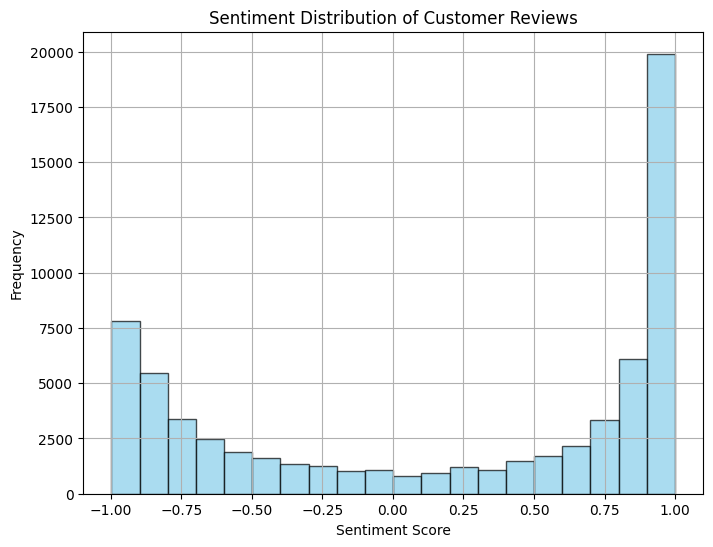

In [10]:
# Plot sentiment distribution
plt.figure(figsize=(8, 6))
df['sentiment_score'].hist(bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Sentiment Distribution of Customer Reviews')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Display sample data with sentiment scores
print("\nSample data with sentiment scores:")
print(df[['customer_review', 'sentiment_score']].head())


Sample data with sentiment scores:
                                     customer_review  sentiment_score
1  âœ… Trip Verified | London to Izmir via Istanb...           0.9365
3  âœ… Trip Verified | Istanbul to Bucharest. We ...           0.2732
5  âœ… Trip Verified | Rome to Prishtina via Ista...          -0.9483
7  âœ… Trip Verified | Flew on Turkish Airlines I...           0.9718
9  âœ… Trip Verified | Mumbai to Dublin via Istan...          -0.7599


In [12]:
# Group the dataset by airline and calculate the mean ratings for each service aspect
airline_ratings = df.groupby('airline')[['seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money']].mean()

# Calculate the overall rating for each airline
airline_ratings['overall_rating'] = airline_ratings.mean(axis=1)

# Rank the airlines based on their overall ratings
ranked_airlines = airline_ratings.sort_values(by='overall_rating', ascending=False)

# Display the ranked airlines
print("Ranking of Airlines based on Overall Ratings:")
print(ranked_airlines[['overall_rating']])


Ranking of Airlines based on Overall Ratings:
                         overall_rating
airline                                
Garuda Indonesia               4.194009
EVA Air                        4.122622
China Southern Airlines        4.059732
ANA All Nippon Airways         4.050977
Asiana Airlines                4.039396
...                                 ...
American Airlines              2.090102
Vueling Airlines               1.904028
WOW air                        1.903872
Frontier Airlines              1.717972
Spirit Airlines                1.660247

[81 rows x 1 columns]


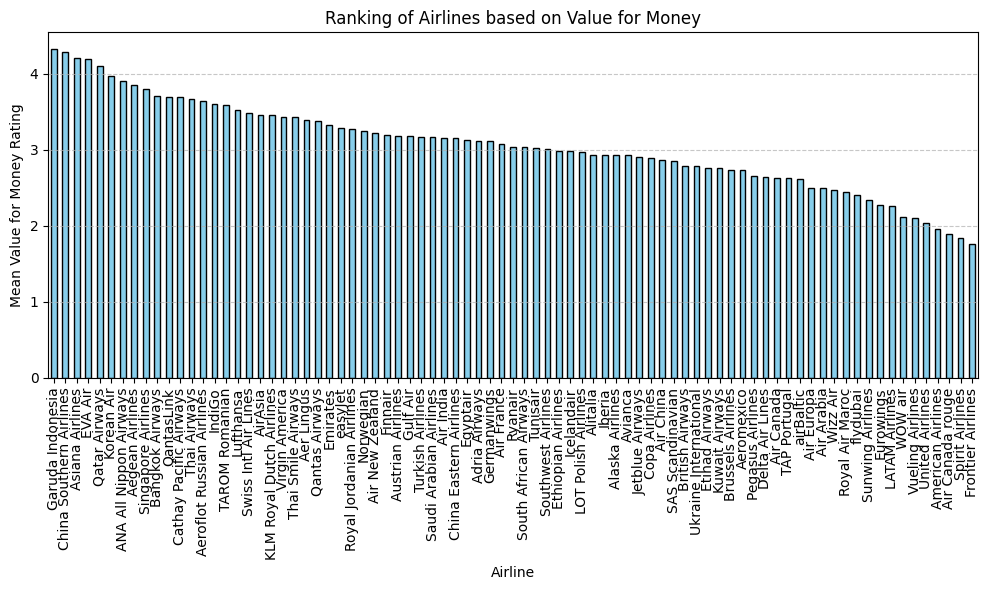

In [13]:
import matplotlib.pyplot as plt

# Group the dataset by airline and calculate the mean value_for_money ratings for each airline
value_for_money_ratings = df.groupby('airline')['value_for_money'].mean()

# Rank the airlines based on their mean value_for_money ratings
ranked_airlines_value_for_money = value_for_money_ratings.sort_values(ascending=False)

# Plot the histogram of value_for_money ratings
plt.figure(figsize=(10, 6))
ranked_airlines_value_for_money.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Ranking of Airlines based on Value for Money')
plt.xlabel('Airline')
plt.ylabel('Mean Value for Money Rating')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [15]:
# Function to suggest airlines based on user preferences
def suggest_airlines(df, preferences):
    # Calculate composite score for each airline based on user preferences
    df['composite_score'] = (df['value_for_money'] * preferences['value_for_money'] +
                             df['recommended'].map({'yes': 1, 'no': 0}) * preferences['recommended'] +
                             df['overall'] / 10 * preferences['overall_rating'])

    # Rank the airlines based on composite scores
    ranked_airlines = df.sort_values(by='composite_score', ascending=False)

    # Get top N recommendations
    top_n = 5
    recommendations = ranked_airlines[['airline', 'composite_score']].head(top_n)

    return recommendations

# Example user preferences
user_preferences = {
    'value_for_money': 0.3,
    'recommended': 0.2,
    'overall_rating': 0.5
}

# Suggest airlines based on user preferences
user_recommendations = suggest_airlines(df, user_preferences)

# Display recommendations
print("Top Airlines Recommendations based on User Preferences:")
print(user_recommendations)



Top Airlines Recommendations based on User Preferences:
                airline  composite_score
39267          Alitalia              2.2
110956  Spirit Airlines              2.2
110968  Spirit Airlines              2.2
110966  Spirit Airlines              2.2
14613    Virgin America              2.2


In [16]:
# Function to suggest airlines based on user preferences
def suggest_airlines(df):
    # Prompt user to input preferences
    print("Please rate each parameter from 1 to 5 (5 being the highest):")
    preferences = {}
    for parameter in ['value_for_money', 'recommended', 'overall_rating']:
        rating = float(input(f"Rate {parameter.replace('_', ' ').title()}: "))
        preferences[parameter] = rating / 5  # Normalize rating to range between 0 and 1

    # Calculate composite score for each airline based on user preferences
    df['composite_score'] = (df['value_for_money'] * preferences['value_for_money'] +
                             df['recommended'].map({'yes': 1, 'no': 0}) * preferences['recommended'] +
                             df['overall'] / 10 * preferences['overall_rating'])

    # Rank the airlines based on composite scores
    ranked_airlines = df.sort_values(by='composite_score', ascending=False)

    # Get top N recommendations
    top_n = 5
    recommendations = ranked_airlines[['airline', 'composite_score']].head(top_n)

    return recommendations

# Suggest airlines based on user preferences
user_recommendations = suggest_airlines(df)

# Display recommendations
print("Top Airlines Recommendations based on User Preferences:")
print(user_recommendations)


Please rate each parameter from 1 to 5 (5 being the highest):
Rate Value For Money: 4
Rate Recommended: 4
Rate Overall Rating: 3
Top Airlines Recommendations based on User Preferences:
                  airline  composite_score
35169          Aeromexico              5.4
24957  Southwest Airlines              5.4
72051      Etihad Airways              5.4
16481   American Airlines              5.4
72031      Etihad Airways              5.4


In [19]:
# Function to compare airlines based on selected parameters
def compare_airlines(df):
    # Prompt user to select parameters
    selected_parameters = []
    print("Select parameters you want to compare (enter 'done' when finished):")
    while True:
        parameter = input("Enter parameter (e.g., value_for_money, recommended, overall_rating): ")
        if parameter.lower() == 'done':
            break
        if parameter in df.columns:
            selected_parameters.append(parameter)
        else:
            print("Invalid parameter! Please enter a valid parameter.")

    if not selected_parameters:
        print("No parameters selected. Exiting.")
        return

    # Calculate composite score for each airline based on selected parameters
    df['composite_score'] = df[selected_parameters].mean(axis=1)

    # Rank the airlines based on composite scores
    ranked_airlines = df.sort_values(by='composite_score', ascending=False)

    return ranked_airlines[['airline', 'composite_score']]

# Compare airlines based on selected parameters
selected_airlines = compare_airlines(df)

# Display comparison results
if selected_airlines is not None and not selected_airlines.empty:
    print("Airlines Ranking based on Selected Parameters:")
    print(selected_airlines)
else:
    print("No comparison results to display.")



Select parameters you want to compare (enter 'done' when finished):
Enter parameter (e.g., value_for_money, recommended, overall_rating): recommended
Enter parameter (e.g., value_for_money, recommended, overall_rating): 
Invalid parameter! Please enter a valid parameter.
Enter parameter (e.g., value_for_money, recommended, overall_rating): value_for_money
Enter parameter (e.g., value_for_money, recommended, overall_rating): overall_rating
Invalid parameter! Please enter a valid parameter.


KeyboardInterrupt: Interrupted by user

In [ ]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('vader_lexicon')

# Load the dataset
df = pd.read_excel('cargoairways.xlsx')

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("Columns:", df.columns)
print("\nSample data:")
print(df.head())

# Sentiment analysis
sid = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['customer_review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Define features and target variable
X = df[['seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'sentiment_score']]
y = df['recommended'].map({'yes': 1, 'no': 0})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Feature importance
feature_importance = rf_classifier.feature_importances_
features = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Predictions and evaluation
y_pred = rf_classifier.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
